In [108]:
#Imports
import os
import re
import cv2
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import glob
import shutil



In [109]:
#Project Paths
# Adjust this if notebook is moved
#Project Paths # Adjust this if notebook is moved 
from pathlib import Path

# Explicitly set the base data directory to your given path (Windows path with raw string)
DATA_DIR = Path(r"C:\Users\Admin\Desktop\RL Image Registration\data")

# Raw data folders (optional, keep if needed)
RAW_DIR = DATA_DIR / "raw"
SAR_RAW_DIR = RAW_DIR / "SAR"
OPT_RAW_DIR = RAW_DIR / "Optical"

# Preprocessed output base folder
OUT_BASE = DATA_DIR / "preprocessed"

# Subfolders inside preprocessed
OPT_OUT = OUT_BASE / "optical_fixed"
SAR_OUT = OUT_BASE / "sar_preprocessed"
MIS_OUT = OUT_BASE / "sar_misaligned"
META_OUT = OUT_BASE / "meta"

# Create directories if they don't exist
for d in [OPT_OUT, SAR_OUT, MIS_OUT, META_OUT]:
    d.mkdir(parents=True, exist_ok=True)

print("Output directories ready at:", OUT_BASE)

# debug
print("OPT_OUT:", OPT_OUT)
print("SAR_OUT:", SAR_OUT)
print("MIS_OUT:", MIS_OUT)
# Assuming sar_paths and opt_paths are defined in your code elsewhere
print(f"Found {len(sar_paths)} SAR images and {len(opt_paths)} Optical images")



Output directories ready at: C:\Users\Admin\Desktop\RL Image Registration\data\preprocessed
OPT_OUT: C:\Users\Admin\Desktop\RL Image Registration\data\preprocessed\optical_fixed
SAR_OUT: C:\Users\Admin\Desktop\RL Image Registration\data\preprocessed\sar_preprocessed
MIS_OUT: C:\Users\Admin\Desktop\RL Image Registration\data\preprocessed\sar_misaligned
Found 10586 SAR images and 10586 Optical images


In [110]:
#Pair Matching 
def extract_key(path: Path): 
    match = re.search(r'_s[12]_(\d+)_p(\d+)$', path.stem) 
    if match: 
        return (match.group(1), int(match.group(2))) 
    return None 

sar_map = {extract_key(p): p for p in sar_paths if extract_key(p)} 
opt_map = {extract_key(p): p for p in opt_paths if extract_key(p)} 

common_keys = sorted(set(sar_map.keys()) & set(opt_map.keys())) 

sar_paths = [sar_map[k] for k in common_keys] 
opt_paths = [opt_map[k] for k in common_keys] 

print(f"Matched SAR–Optical pairs: {len(common_keys)}")

Matched SAR–Optical pairs: 10586


In [111]:
#Advanced Preprocessing
def normalize(img, method='percentile'):
    if method == 'minmax':
        return (img - img.min()) / (img.max() - img.min() + 1e-8)
    elif method == 'percentile':
        p2, p98 = np.percentile(img, [2, 98])
        img = np.clip(img, p2, p98)
        return (img - p2) / (p98 - p2 + 1e-8)


In [112]:
def denoise_sar(img):
    return cv2.fastNlMeansDenoising(
        (img * 255).astype(np.uint8),
        None, 10, 7, 21
    ).astype(np.float32) / 255.0


In [113]:
def enhance_contrast(img):
    img_u8 = (img * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(2.0, (8, 8))
    return clahe.apply(img_u8).astype(np.float32) / 255.0


In [114]:
def preprocess_pair(sar_path, opt_path, size=256):
    sar = cv2.imread(str(sar_path), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    opt = cv2.imread(str(opt_path), cv2.IMREAD_GRAYSCALE).astype(np.float32)

    sar = cv2.resize(sar, (size, size))
    opt = cv2.resize(opt, (size, size))

    sar = np.log1p(sar)
    sar = denoise_sar(normalize(sar))
    opt = normalize(opt)

    sar = enhance_contrast(sar)
    opt = enhance_contrast(opt)

    return sar, opt


In [116]:
#Improved Misalignment
def random_transform():
    return {
        "tx": random.randint(-15, 15),
        "ty": random.randint(-15, 15),
        "angle": random.uniform(-10, 10),
        "scale": random.uniform(0.95, 1.05)
    }


In [117]:
def apply_transform(img, t):
    h, w = img.shape
    M = cv2.getRotationMatrix2D((w/2, h/2), t["angle"], t["scale"])
    M[0,2] += t["tx"]
    M[1,2] += t["ty"]
    return cv2.warpAffine(img, M, (w, h))


In [124]:
#Run & Save Dataset
for sar_p, opt_p in tqdm(zip(sar_paths, opt_paths), total=len(sar_paths)):
    name = sar_p.stem

    sar, opt = preprocess_pair(sar_p, opt_p)
    t = random_transform()
    sar_mis = apply_transform(sar, t)

    cv2.imwrite(str(OPT_OUT / f"{name}_opt.png"), (opt*255).astype(np.uint8))
    # save preprocessed SAR (primary)
    cv2.imwrite(str(SAR_OUT / f"{name}_sar.png"), (sar*255).astype(np.uint8))
    # save misaligned version
    cv2.imwrite(str(MIS_OUT / f"{name}_mis.png"), (sar_mis*255).astype(np.uint8))

    with open(META_OUT / f"{name}.json", "w") as f:
        json.dump(t, f)


100%|██████████| 10586/10586 [18:57<00:00,  9.31it/s]


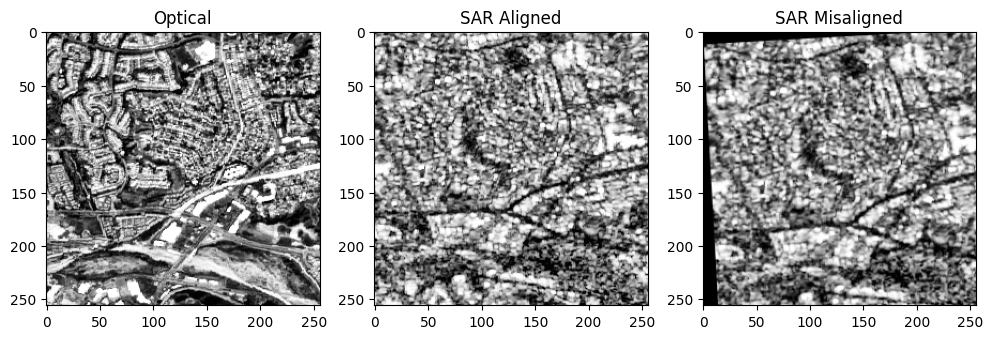

In [121]:
#Visualization
idx = random.randint(0, len(sar_paths)-1) 
sar, opt = preprocess_pair(sar_paths[idx], opt_paths[idx]) 
t = random_transform() 
sar_mis = apply_transform(sar, t) 
plt.figure(figsize=(12,4)) 
plt.subplot(1,3,1); 
plt.imshow(opt, cmap='gray'); 
plt.title("Optical") 
plt.subplot(1,3,2); 
plt.imshow(sar, cmap='gray'); 
plt.title("SAR Aligned") 
plt.subplot(1,3,3); 
plt.imshow(sar_mis, cmap='gray'); 
plt.title("SAR Misaligned") 
plt.show()


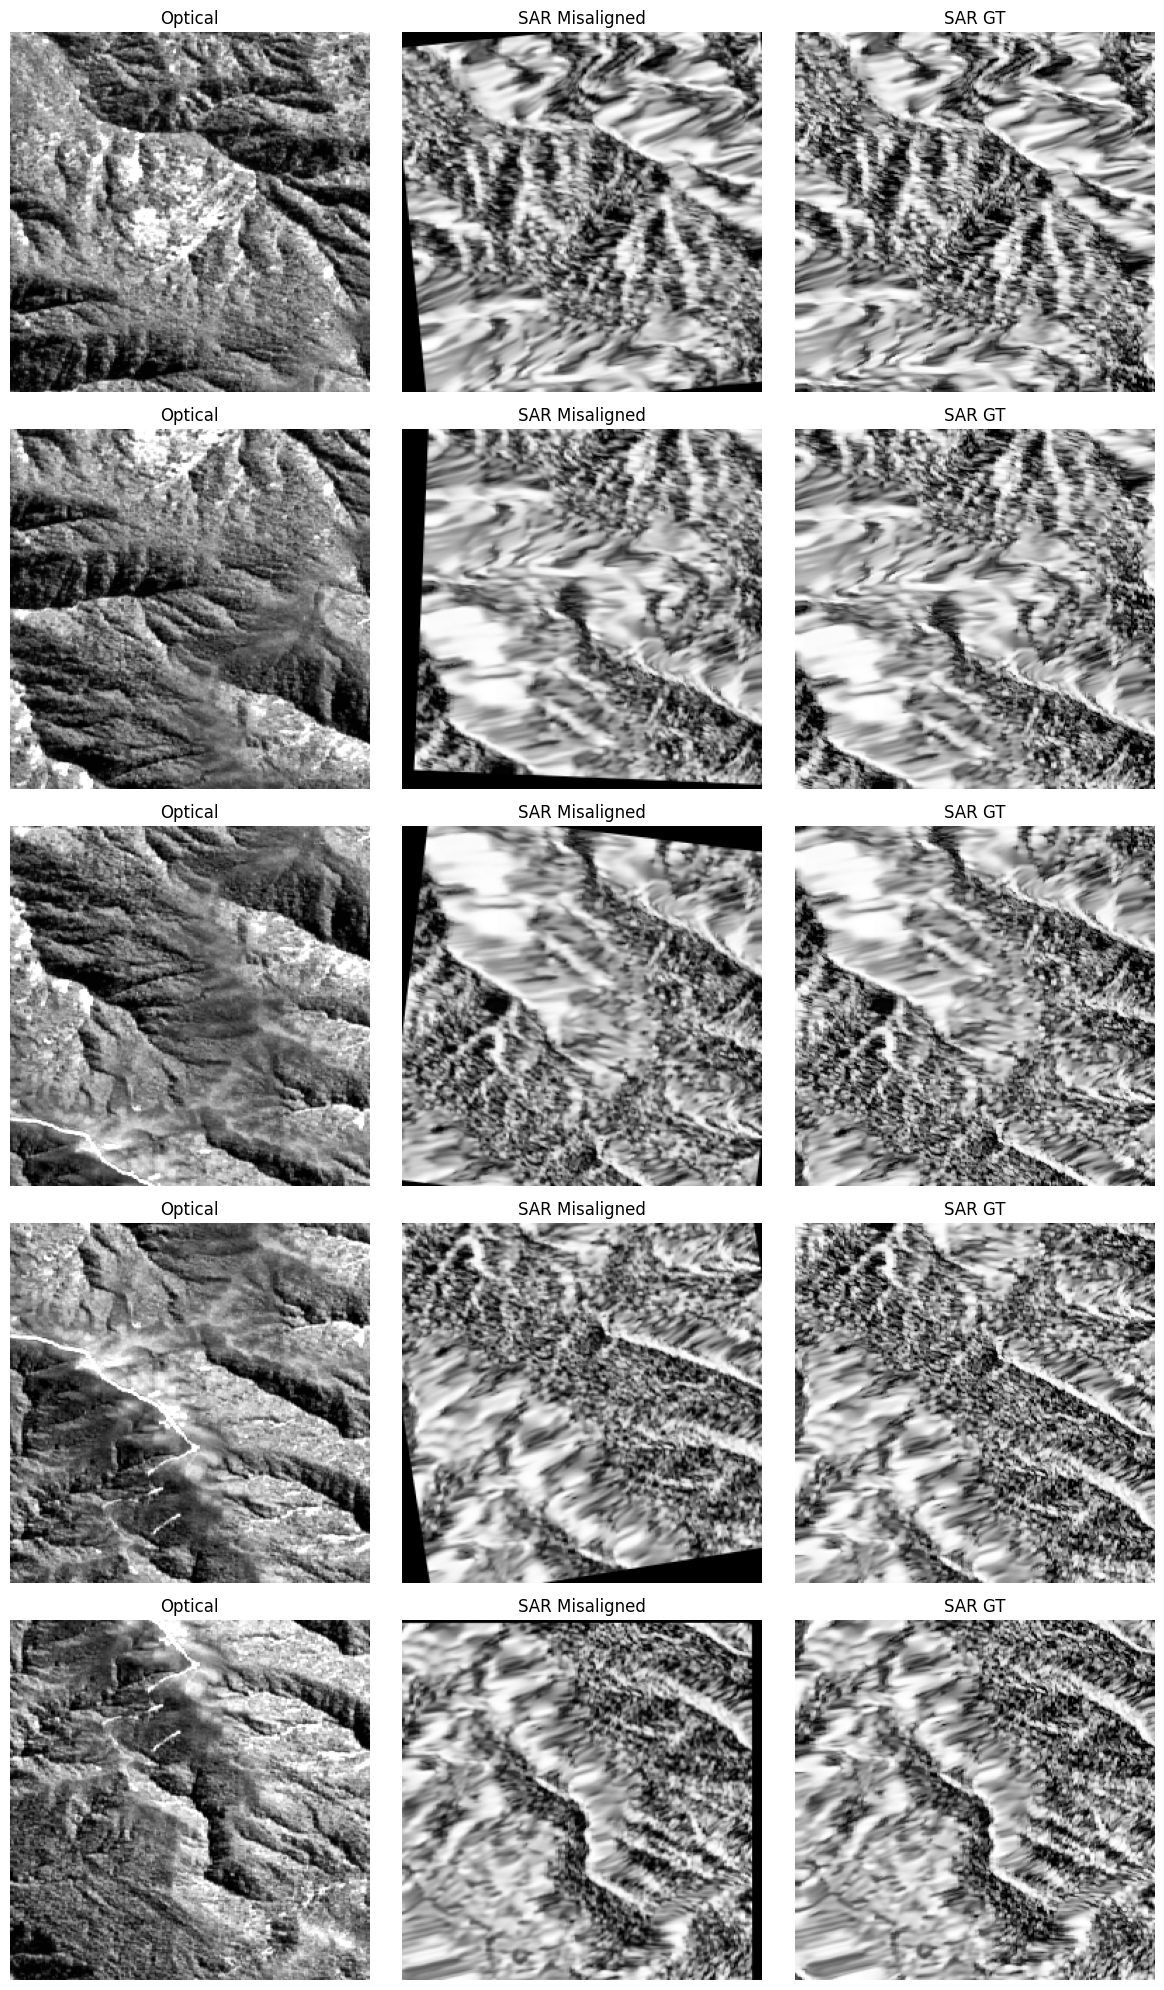

In [122]:
#Visualize Saved Results
opt_imgs = sorted(glob.glob(str(OPT_OUT / "*.png")))
sar_imgs = sorted(glob.glob(str(SAR_OUT / "*.png")))
mis_imgs = sorted(glob.glob(str(MIS_OUT / "*.png")))

n = 5
plt.figure(figsize=(12, 4*n))

for i in range(n):
    opt = cv2.imread(opt_imgs[i], 0) / 255.0
    sar = cv2.imread(sar_imgs[i], 0) / 255.0
    mis = cv2.imread(mis_imgs[i], 0) / 255.0

    plt.subplot(n,3,3*i+1)
    plt.imshow(opt, cmap='gray')
    plt.title("Optical")
    plt.axis('off')

    plt.subplot(n,3,3*i+3)
    plt.imshow(sar, cmap='gray')
    plt.title("SAR GT")
    plt.axis('off')

    plt.subplot(n,3,3*i+2)
    plt.imshow(mis, cmap='gray')
    plt.title("SAR Misaligned")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [123]:

# ==============================
# Paths
# ==============================
BASE = DATA_DIR 
# / "data" / "preprocessed"

TRAIN_BASE = BASE / "train"
TEST_BASE  = BASE / "test"

SUBFOLDERS = ["optical_fixed", "sar_preprocessed", "sar_misaligned", "meta"]

# Create train/test folders
for base in [TRAIN_BASE, TEST_BASE]:
    for sf in SUBFOLDERS:
        (base / sf).mkdir(parents=True, exist_ok=True)

# ==============================
# Collect sample IDs
# ==============================
opt_files = sorted(OPT_OUT.glob("*_opt.png"))
samples = [f.stem.replace("_opt", "") for f in opt_files]

print(f"Total samples found: {len(samples)}")

# ==============================
# Shuffle & split
# ==============================
random.seed(42)
random.shuffle(samples)

split_idx = int(0.8 * len(samples))
train_ids = samples[:split_idx]
test_ids  = samples[split_idx:]

# ==============================
# Move function
# ==============================
def move_sample(sid, target):
    shutil.move(OPT_OUT  / f"{sid}_opt.png",
                target / "optical_fixed" / f"{sid}_opt.png")

    shutil.move(SAR_OUT  / f"{sid}_sar.png",
                target / "sar_preprocessed" / f"{sid}_sar.png")

    shutil.move(MIS_OUT  / f"{sid}_mis.png",
                target / "sar_misaligned" / f"{sid}_mis.png")

    shutil.move(META_OUT / f"{sid}.json",
                target / "meta" / f"{sid}.json")

# ==============================
# Move files
# ==============================
for sid in train_ids:
    move_sample(sid, TRAIN_BASE)

for sid in test_ids:
    move_sample(sid, TEST_BASE)

print(f"✅ Train samples: {len(train_ids)}")
print(f"✅ Test samples:  {len(test_ids)}")


Total samples found: 10586
✅ Train samples: 8468
✅ Test samples:  2118
